![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 13 - Bayesian Regression </center>
### <center> Bayesian Optimization </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/13_BayesianRegression/MainGlobalBayesianOptimization.ipynb)

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

### Generate some data:
$$\mathcal{D}_{\text{train}}=\left\{ \left(x_{i},y_{i}\right)\right\} _{i=1}^{N}$$
$$y_{i}=f\left(x_{i}\right)+\epsilon_{i}$$

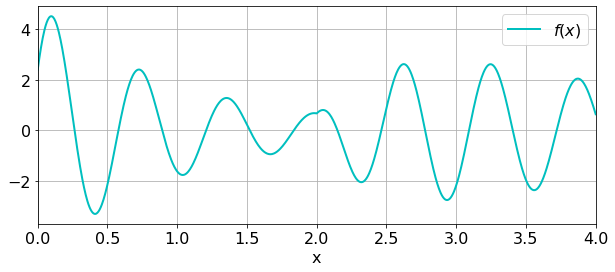

In [2]:
def f(vX):
    return 5 * np.exp(-vX) * np.sin(10*vX + .5) * (1 + (vX > 2) * 10 * (vX - 2))

M  = 1001;
xx = np.linspace(0, 4, M);

plt.figure(figsize=(10, 4))
plt.plot  (xx, f(xx), 'c', lw=2, label='$f(x)$')
plt.xlim  ([0, 4])
plt.xlabel('x')
plt.grid  ()
plt.legend()
plt.show  ()

###  Bayesian optimization:
$$\boldsymbol{x}_{t}\leftarrow\arg\underset{\boldsymbol{x}_{0}\in\mathcal{X}}{\min}\mu_{y_{0}}-\tau\sigma_{y_{0}}$$

In [3]:
from sklearn.gaussian_process         import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

def PlotBayesianOptimization(N, α=0.01, τ=2):
    
    oKernel = RBF(length_scale=.1, length_scale_bounds='fixed') + WhiteKernel(0.01, noise_level_bounds='fixed')

    mX = np.full((N, 1), np.nan)
    vY = np.full(N,      np.nan)
    for ii in range(N):
        if ii == 0:
            mX[0,:] = 2          #-- a random point
            vY[0]   = f(mX[0,:])
        else:
            mX[ii,:] = xx[idx]
            vY[ii]   = f(xx[idx])

        mXi    = mX[:ii+1,:]
        vYi    = vY[:ii+1]
        oGPR   = GaussianProcessRegressor(kernel=oKernel, alpha=α).fit(mXi, vYi)
        yy, σσ = oGPR.predict(xx[:,None], return_std=True)
        idx    = np.argmin(yy - τ * σσ)

    plt.figure      (figsize=(16, 6))
    plt.fill_between(xx, yy - τ*σσ, yy + τ*σσ, color='gray', alpha=0.3, label='$\pm τ\sigma_{y}$')
    plt.scatter     (mX[:,0], vY, s=50, c='b', edgecolor='k',           label='$y_i = f(x_i) + \epsilon_i$')
    plt.plot        (xx, f(xx), 'c',   lw=2,                            label='$f(x)$')
    plt.plot        (xx, yy,    '--r', lw=2,                            label='$\hat{f}(x)$')
    plt.axvline     (x=xx[idx],        lw=2, ls='--', c='g')
    plt.xlabel      ('x')
    plt.grid        ()
    plt.legend      (fontsize=14, loc='lower right')


$$\boldsymbol{x}_{t}\leftarrow\arg\underset{\boldsymbol{x}_{0}\in\mathcal{X}}{\min}\mu_{y_{0}}-\tau\sigma_{y_{0}}$$

In [4]:
from ipywidgets import interact, IntSlider, FloatSlider, Layout

αSlider = FloatSlider(min=0.0001, max=1,   step=0.001, value=0.1, layout=Layout(width='80%'))
nSlider = IntSlider  (min=1,      max=100, step=1,     value=1,   layout=Layout(width='80%'))
τSlider = IntSlider  (min=1,      max=100, step=1,     value=10,  layout=Layout(width='80%'))
interact(PlotBayesianOptimization, N=nSlider, α=αSlider, τ=τSlider)
plt.show()


interactive(children=(IntSlider(value=1, description='N', layout=Layout(width='80%'), min=1), FloatSlider(valu…

### Boston data:

In [5]:
from sklearn.datasets import load_boston

mX, vY = load_boston(return_X_y=True)
mX.shape, vY.shape

((506, 13), (506,))

In [6]:
N   = mX.shape[0]
mX -= mX.mean(axis=0)
mX /= mX.std (axis=0)
vY -= vY.mean()
vY /= vY.std ()

### The function to minimize:
We use $-R^2$ score (with cross validation).  
$\gamma$ is the unknown parameter.

In [10]:
from sklearn.kernel_ridge    import KernelRidge
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics         import r2_score

def CrossValScore(ɣ, kFold=50):
    vHatY = cross_val_predict(KernelRidge(kernel='rbf', gamma=10**ɣ, alpha=0.016), mX, vY, cv=KFold(kFold, shuffle=True))
    return -r2_score(vY, vHatY)

In [11]:
-CrossValScore(0.01)

0.6846261170623866

#### Bayesian optimization:

In [12]:
from sklearn.gaussian_process         import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

def BayesianOptimization(f, N, XX, 𝜏=2):

#     oKernel = RBF(length_scale=.05, length_scale_bounds='fixed') + WhiteKernel(0.01, noise_level_bounds='fixed')
    oKernel = RBF(length_scale=.2, length_scale_bounds='fixed') + WhiteKernel(0.005, noise_level_bounds='fixed')
    M, d    = XX.shape
    mX = np.full((N, d), np.nan)
    vY = np.full(N,      np.nan)
    for ii in range(N):
        print(f'\r{N - ii:03d}', end='')
        
        if ii == 0:
            idx = np.random.randint(M)
        
        mX[ii,:] = XX[idx,:]
        vY[ii]   = f(*mX[ii,:])

        mXi    = mX[:ii+1,:]
        vYi    = vY[:ii+1]
        oGPR   = GaussianProcessRegressor(kernel=oKernel, alpha=0.01**2).fit(mXi, vYi)
        yy, σσ = oGPR.predict(XX, return_std=True)
        idx    = np.argmin(yy - 𝜏 * σσ)
               
    return mX, vY, yy, σσ

### Apply algorithm:

In [15]:
#-- Search interval:
vɣ               = np.linspace(-2, -0.8, 501)
#-- Apply algorithm:
mXX, vYY, yy, σσ = BayesianOptimization(CrossValScore, 100, vɣ[:,None], 𝜏=3.5)

mXX.shape, vYY.shape, yy.shape, σσ.shape

001

((100, 1), (100,), (501,), (501,))

 #### Plot:

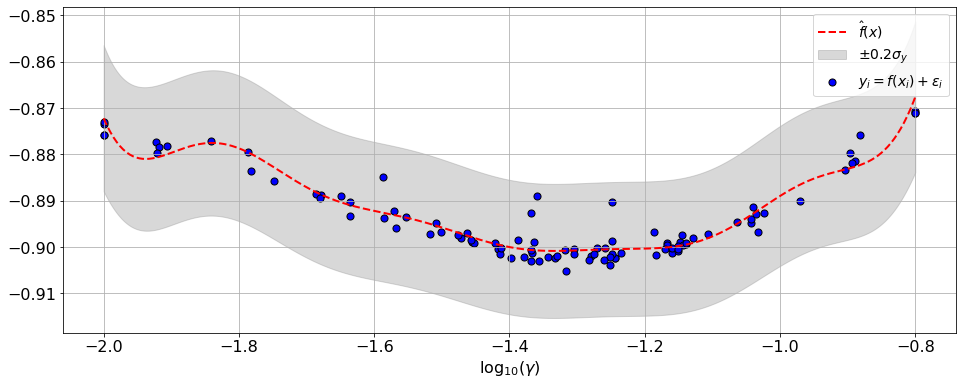

In [16]:
vXX = mXX.squeeze()

plt.figure      (figsize=(16, 6))
plt.fill_between(vɣ,  yy -.2*σσ, yy + .2*σσ, color='gray', alpha=0.3, label='$\pm 0.2\sigma_{y}$')
plt.plot        (vɣ,  yy, '--r', lw=2,                                label='$\hat{f}(x)$')
plt.scatter     (vXX, vYY, s=50, c='b', edgecolor='k',                label='$y_i = f(x_i) + \epsilon_i$')
plt.xlabel      ('$\log_{10}(\gamma)$')
plt.legend      (fontsize=14)
plt.grid        ()
plt.show        ()

#### Best $\gamma$:

In [18]:
idx = np.where(vYY == vYY.min())
ɣ   = vXX[idx]
ɣ

array([-1.316])

In [19]:
-vYY.min()

0.9051162812363172

#### $R^2$ score:
(with the best $\gamma$)

In [22]:
-CrossValScore(ɣ, kFold=N)

0.9022498371798315

### Exercise
* Search for both $\gamma$ and $\alpha$.
* Improve the $R^2$ score.

In [67]:
from sklearn.kernel_ridge    import KernelRidge
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics         import r2_score

def CrossValScore(ɣ, α, kFold=50):
    ???

In [23]:
#-- Search interval:
vɣ     = np.linspace(-2.0, -1.00, 101)
vα     = np.linspace(-2.5, -1.25, 101)
mɣ, mα = np.meshgrid(vɣ, vα)

???

Object `?` not found.


 #### Plot:

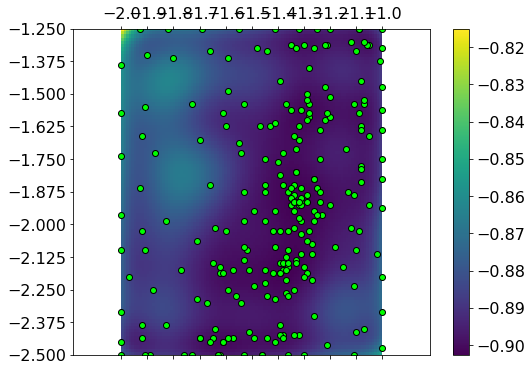

In [10]:
mYY   = np.reshape(yy, mɣ.shape)
_, ax = plt.subplots(figsize=(8, 6))

c = ax.matshow(mYY, extent=[vɣ.min(), vɣ.max(), vα.min(), vα.max()], origin='lower')
plt.scatter   (mXX[:,0], mXX[:,1], c='lime', edgecolor='k')
ax.set_xticks (vɣ[::10])
ax.set_yticks (vα[::10])
plt.colorbar  (c, ax=ax)
plt.axis      ('equal')
plt.show      ()

In [14]:
yIdx, xIdx = np.where(mYY == mYY.min())
ɣ,    α    = vɣ[xIdx], vα[yIdx]
-CrossValScore(ɣ, α, kFold=N)

0.9025898077882599